## real/generated images

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [7]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['EnergyDeposit'].reshape(-1, 1, 30, 30)
        self.point = self.data['ParticlePoint']
        self.momentum = self.data['ParticleMomentum']

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "image": self.image[i],
            "point": self.point[i],
            "momentum": self.momentum[i]
        }

In [10]:
real_data = ParticleDataset('data/real_data.npz')
fake_data1 = ParticleDataset('data/fake_data.npz')
fake_data2 = ParticleDataset('data/fake_VAE_1.npz')

In [11]:
feats_real = real_data.image.reshape(-1, 900)
feats_gen_1 = fake_data1.image.reshape(-1, 900)
feats_gen_2 = fake_data2.image.reshape(-1, 900)

**В качестве фич берется значение пикселей. Возможен перевод картинка->эмбеддинг например с помощью 1-ой части Inception network (feture extraxtor). Тогда фичи - это эмбеддинг**

In [42]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, number_of_bins=25):
    model = MiniBatchKMeans(n_clusters=number_of_bins, n_init=10)
    print ("real_data.shape", real_data.shape)
    print ("generated_data.shape", generated_data.shape)
    print (np.vstack((real_data, generated_data)).shape)
    labels = model.fit_predict(np.vstack((real_data, generated_data)))
    real_density, real_edges = np.histogram(labels[:len(real_data)], bins=number_of_bins,
                           range=[0, number_of_bins], density=True)
    gen_density, gen_edges = np.histogram(labels[len(real_data):], bins=number_of_bins,
                          range=[0, number_of_bins], density=True)
    return real_density, gen_density

In [56]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    for k in np.tan(angles):
        #k = math.tan(float(i)/(2*num_angles + 2)*math.pi)
        #print ("k", k)
        mins_a = [min(l1, l2) for l1, l2 in zip(k*real_density, gen_density)]
        alpha_vec.append(np.sum(np.array(mins_a)))
        mins_b = [min(l1, l2) for l1, l2 in zip(real_density, gen_density/k)]
        beta_vec.append(np.sum(np.array(mins_b)))
    return alpha_vec, beta_vec

In [68]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

In [67]:
count_prd(a, b)

(2, 1000)


In [44]:
a, b = bin_counts(feats_real, feats_gen_1)
a2, b2 = bin_counts(feats_real, feats_gen_2)

real_data.shape (29600, 900)
generated_data.shape (29600, 900)
(59200, 900)
real_data.shape (29600, 900)
generated_data.shape (29600, 900)
(59200, 900)


In [71]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(a2, b2)

(2, 1000)
(2, 1000)


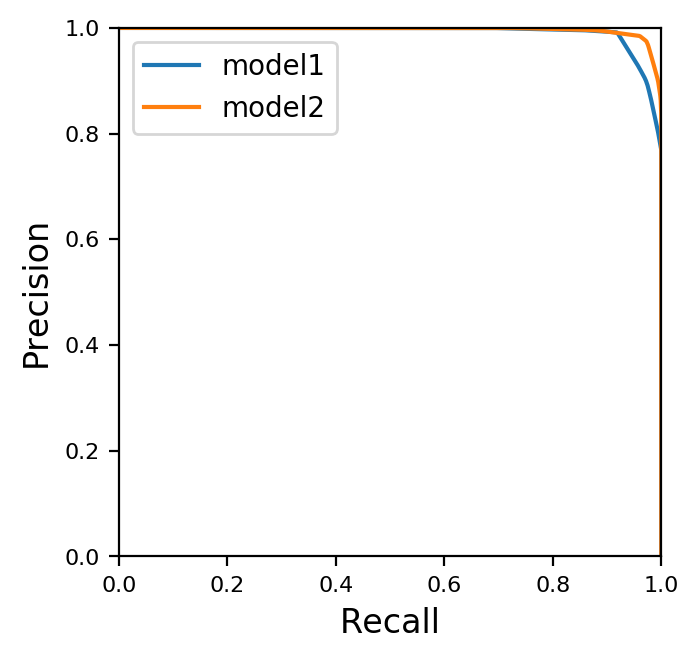

In [80]:
fig = plt.figure(figsize=(3.5, 3.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "model1")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "model2")
plt.legend()
plt.show()

# Бибилиотечная ф-ция

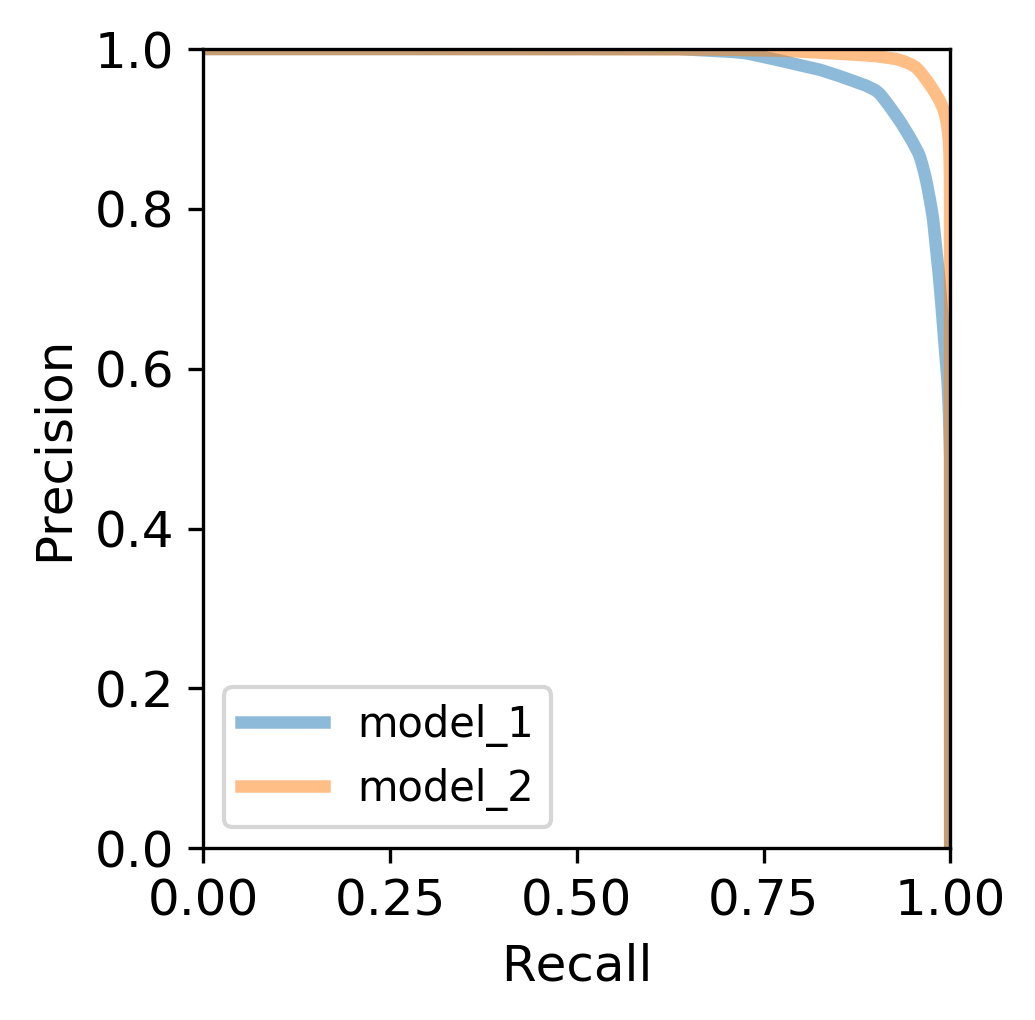

In [29]:
import prd_score as prd

prd_data_1 = prd.compute_prd_from_embedding(feats_real, feats_gen_1)
prd_data_2 = prd.compute_prd_from_embedding(feats_real, feats_gen_2)
prd.plot([prd_data_1, prd_data_2], ['model_1', 'model_2'])